# Integrating scRNA and protein in bone marrow cells

Given two single-cell datasets profiled with different modalities scConfluence can map each in low-dimensional latent space shared by both modalities where distances between cell embeddings depends only on their biological similarity. We show here an example of integration on a bone marrow dataset where gene expression and protein abundance were measured.

## Prerequisites

scConfluence is well integrated within the scverse framework. Therefore the input data is loaded from a MuData object and preprocessed using `scanpy` and `muon` following common practices in the literature such as the one described in this [book](https://www.sc-best-practices.org/preamble.html). For the purpose of this tutorial, we assume that the user is familiar with the basics of single-cell data analysis and the scverse framework.


## Imports

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.spatial.distance import cdist
import muon as mu
import numpy as np
import scanpy as sc
import torch
torch.manual_seed(1792)

import scconfluence

/pasteur/appa/homes/jsamaran/venvs/clean_conf/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Read data

You can download the unpaired multimodal demo dataset for this tutorial from https://figshare.com/s/f2623d650c3b93cb1d6f.

In [2]:
mdata = mu.read_h5mu("RNA_PROT_demo.h5mu.gz")
mdata

MuData object with n_obs × n_vars = 8000 × 14087
  obs:	'celltype', 'batch', 'modality'
  var:	'feature_types', 'gene_id'
  2 modalities
    rna:	4000 x 13953
      obs:	'batch', 'celltype'
    adt:	4000 x 134
      obs:	'batch', 'celltype'
      var:	'gene_connection'

## Perform basic quality control

We can use scanpy functions to filter out cells or features with low quality measurements, more advanced quality control could be appropriate depending on the technologies used to obtain the data.

In [3]:
sc.pp.filter_cells(mdata["rna"], min_genes=100)
sc.pp.filter_genes(mdata["rna"], min_cells=20)

sc.pp.filter_cells(mdata["adt"], min_genes=10)
# we're actually filtering proteins here
sc.pp.filter_genes(mdata["adt"], min_cells=20)
mdata.update()
mdata

MuData object with n_obs × n_vars = 8000 × 13865
  obs:	'celltype', 'batch', 'modality'
  var:	'n_cells', 'feature_types', 'gene_id'
  2 modalities
    rna:	4000 x 13731
      obs:	'batch', 'celltype', 'n_genes'
      var:	'n_cells'
    adt:	4000 x 134
      obs:	'batch', 'celltype', 'n_genes'
      var:	'gene_connection', 'n_cells'

## Preprocess common features and obtain cross-modality distance matrix

Diagonal integration, i.e. single cell multimodal unpaired integration, is a very challenging task as it aims at aligning cells in which different features were measured. To guide the alignment, we need to leverage prior biological knowledge to obtain a set of common features across modalities which will serve as a bridge for the integration. For RNA-Protein integration, those common features are derived from the matching of proteins with their coding genes. 

In this tutorial, we assume that the user has already identified the coding genes associated to each protein of the adt modality and stored them in the `gene_connection` field of the `var` attribute of the ADT modality.

In [4]:
# Keep only proteins with a gene connection and their corresponding coding genes
cm_genes = list(set(mdata["rna"].var_names) & set(mdata["adt"].var["gene_connection"].values))
cm_features_rna = mdata["rna"][:, cm_genes].copy() 
prot_genes_idx = [list(mdata["adt"].var["gene_connection"].values).index(g) for g in cm_genes]
cm_features_adt = mdata["adt"][:, prot_genes_idx].copy()

In [5]:
# Log-normalize scRNA counts
sc.pp.normalize_total(cm_features_rna, target_sum=10000.)
sc.pp.log1p(cm_features_rna)

# Use the Centered log ratio normalization for protein counts
mu.prot.pp.clr(cm_features_adt, axis=1)

sc.pp.scale(cm_features_rna)
sc.pp.scale(cm_features_adt)

/pasteur/appa/homes/jsamaran/venvs/clean_conf/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:196: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Once those common feature representations have been obtained, we can derive a distance matrix whose rows correspond to cells in the RNA modality and columns correspond to the cells in the ADT modality which will be used by scConfluence.

In [6]:
mdata.uns["cross_rna+adt"] = cdist(cm_features_rna.X, cm_features_adt.X, metric="correlation")
mdata.uns["cross_keys"] = ["cross_rna+adt"]

## Preprocess each modality

While the computation of the distance matrix only involved features that were connected across modalities (proteins and their corresponding coding genes), our method leverages all original features to perform dimension reductions. Therefore, we need to preprocess each modality separately once again.

In [7]:
mdata["rna"].layers["counts"] = mdata["rna"].X.copy()

# Log-normalize scRNA counts
sc.pp.normalize_total(mdata["rna"], target_sum=10000.)
sc.pp.log1p(mdata["rna"])

# Since we use both raw and normalized gene counts it makes sense to select highly variable genes based on both criteria
raw_hvg = sc.pp.highly_variable_genes(mdata["rna"], layer="counts", n_top_genes=3000, subset=False, inplace=False, 
                                     flavor="seurat_v3")["highly_variable"].values
norm_hvg = sc.pp.highly_variable_genes(mdata["rna"], n_top_genes=3000, subset=False, 
                                       inplace=False)["highly_variable"].values
mdata.mod["rna"] = mdata["rna"][:, np.logical_or(raw_hvg, norm_hvg)].copy()

# Perform PCA on the selected genes
sc.tl.pca(mdata["rna"], n_comps=100, zero_center=None)

In [8]:
# Use the Centered log ratio normalization for protein counts
mu.prot.pp.clr(mdata["adt"], axis=1)

## Define autoencoders for each modality

We define one autoencoder per modality whose aim is to extract all the biological information present in the original features while accounting for batch effects (not present here since there's only one batch) and projecting the cells to a shared latent space of low dimension (hence the dimension of the latent space `n_latent` should be the same for all autoencoders). 

Multiple options can be set to adapt the autoencoders to the specificity of the modalities measured, see the [API's documention](https://scconfluence.readthedocs.io/en/latest/unimodal.html) for details about the arguments. 

In [9]:
autoencoders = {"rna": scconfluence.unimodal.AutoEncoder(mdata["rna"], 
                                                         modality="rna", 
                                                         rep_in="X_pca", 
                                                         rep_out="counts", 
                                                         batch_key="batch",
                                                         n_hidden=64, 
                                                         n_latent=16,
                                                         type_loss="zinb"),
                "adt": scconfluence.unimodal.AutoEncoder(mdata["adt"], 
                                                         modality="adt", 
                                                         rep_in=None, 
                                                         rep_out=None, 
                                                         batch_key="batch",
                                                         n_hidden=32,#lower than default as there are less features
                                                         n_latent=16,
                                                         type_loss="l2")}

## Create and train the model

The scConfluence model leverages the distance matrix stored in `mdata` to align the latent embeddings learned by autoencoders from each modality. We used here the default parameters, see the [API's documention](https://scconfluence.readthedocs.io/en/latest/model.html) or the [FAQ](https://scconfluence.readthedocs.io/en/latest/faq.html) for details on their meaning. While the maximum over of epochs is set to 1000, we use earlystopping to interrupt the training when the loss has converged on validation samples which generally happens long before the upper limit of 1000 epochs. With a GPU, this training is expected to take less than 5 minutes.

In [10]:
%%time
%%capture
model = scconfluence.model.ScConfluence(mdata=mdata, unimodal_aes=autoencoders, 
                                        mass=0.5, reach=0.3, iot_loss_weight=0.01, sinkhorn_loss_weight=0.1)
model.fit(save_path="demo_rna_adt", use_cuda=True, max_epochs=1000)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: demo_rna_adt/lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type       | Params
------------------------------------
0 | aes  | ModuleDict | 889 K 
------------------------------------
889 K     Trainable params
0         Non-trainable params
889 K     Total params
3.558     Total estimated model params size (MB)
SLURM auto-requeueing enabled. Setting signal handlers.


CPU times: user 2min 13s, sys: 1.61 s, total: 2min 15s
Wall time: 2min 21s


## Obtaining and visualizing latent embeddings of all cells

In [11]:
mdata.obsm["latent"] = model.get_latent(use_cuda=True).loc[mdata.obs_names]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Predicting DataLoader 0: 100%|██████████████████| 16/16 [00:00<00:00, 82.81it/s]


While conclusions should not be drawn from UMAP plots we use it here to visualize the results of the integration.

/pasteur/appa/homes/jsamaran/venvs/clean_conf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/pasteur/appa/homes/jsamaran/venvs/clean_conf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


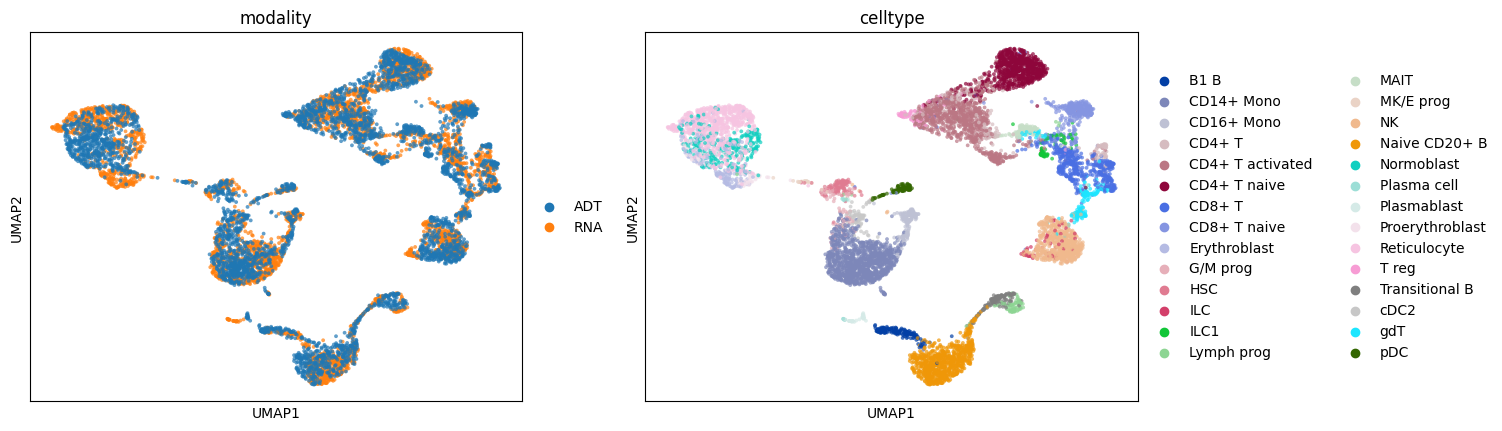

In [12]:
sc.pp.neighbors(mdata, use_rep="latent", key_added="scConfluence")
sc.tl.umap(mdata, neighbors_key="scConfluence")
sc.pl.umap(mdata, color=["modality", "celltype"], size=30, alpha=0.7)

## Clustering the latent embeddings

Once the cells have been projected to the shared latent space, we can use any clustering algorithm to identify groups of cells with similar biological properties. Here we use the Louvain algorithm to cluster the cells.

Since the data was collected from multiple experimental batches, we can also check that they don't form separated clusters in the learned latent space.

/pasteur/appa/homes/jsamaran/venvs/clean_conf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/pasteur/appa/homes/jsamaran/venvs/clean_conf/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


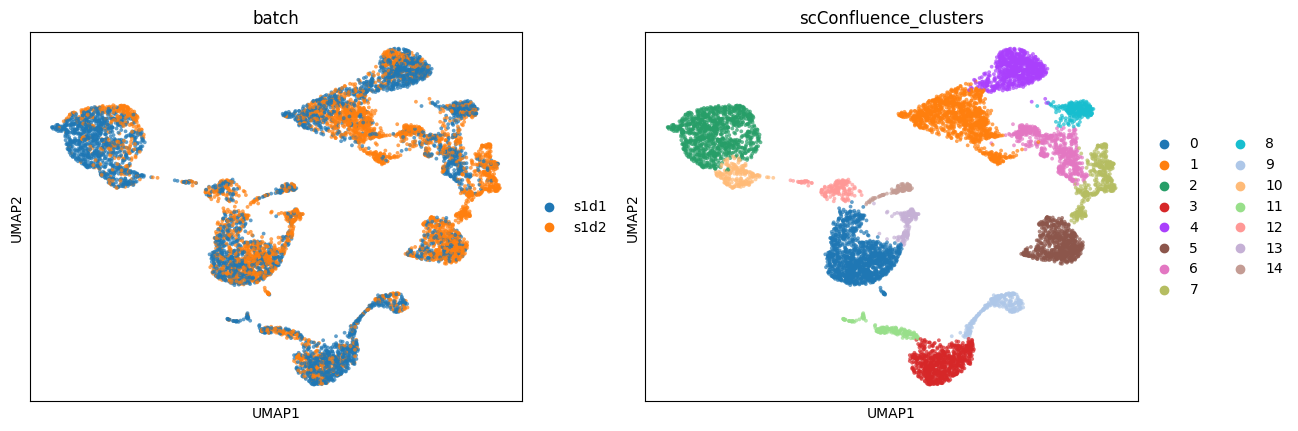

In [13]:
sc.tl.louvain(mdata, resolution=.5, neighbors_key='scConfluence', key_added='scConfluence_clusters')
sc.pl.umap(mdata, color=['batch', 'scConfluence_clusters'], size=30, alpha=0.7)